# Deepfake Detection Pipeline (All Phases in One Notebook)

This notebook is a **single, self-contained pipeline** covering:

- **Phase 1 — Dataset & Preprocessing** (FF++ + Celeb-DF): frame sampling, face crop, RGB + DCT features, splits, saving `.npz`.
- **Phase 2 — Model & Training**: EfficientNetB0 (RGB) + MLP (DCT) hybrid model, training on **FF++**, saving checkpoints.
- **Phase 3 — XAI**: **Grad-CAM** visualization on a chosen sample (no Streamlit demo in this notebook).

### Expected dataset folders (place datasets here)

Put the datasets inside the repo with **this exact structure** (so you don't edit any paths):

- `FF/original/` and `FF/Deepfakes/`
- `Celeb/Celeb-real/` and `Celeb/Celeb-fake/`

In [ ]:

import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Reproducibility (optional)
SEED = 42
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

# Repo paths (assumes notebook is run from repo root)
REPO_ROOT = Path(".").resolve()
PROCESSED_DIR = REPO_ROOT / "processed"
MODEL_DIR = REPO_ROOT / "model"
CKPT_DIR = MODEL_DIR / "checkpoints"
SAVED_DIR = MODEL_DIR / "saved"

# Dataset folders (expected)
FF_REAL_DIR = REPO_ROOT / "FF" / "original"
FF_FAKE_DIR = REPO_ROOT / "FF" / "Deepfakes"
CELE_REAL_DIR = REPO_ROOT / "Celeb" / "Celeb-real"
CELE_FAKE_DIR = REPO_ROOT / "Celeb" / "Celeb-fake"

for p in [FF_REAL_DIR, FF_FAKE_DIR, CELE_REAL_DIR, CELE_FAKE_DIR]:
    if not p.exists():
        raise FileNotFoundError(
            f"Missing folder: {p}\n\n"
            "Expected structure:\n"
            "  FF/original, FF/Deepfakes\n"
            "  Celeb/Celeb-real, Celeb/Celeb-fake\n"
            "Put datasets in those folders (no code edits needed)."
        )

PROCESSED_DIR.mkdir(exist_ok=True, parents=True)
CKPT_DIR.mkdir(exist_ok=True, parents=True)
SAVED_DIR.mkdir(exist_ok=True, parents=True)

print("Repo root:", REPO_ROOT)
print("Processed dir:", PROCESSED_DIR)

Repo root: C:\Users\Omar-\Desktop\DeepFake
Processed dir: C:\Users\Omar-\Desktop\DeepFake\processed


## Phase 1 — Preprocessing (Frames, Face Crop, DCT) → Train/Val/Test `.npz`

In [3]:

# ---------- Helpers: video listing ----------
def list_videos(folder: Path, max_videos: int = 0):
    exts = {".mp4", ".avi", ".mov", ".mkv"}
    files = [p for p in sorted(folder.iterdir()) if p.is_file() and p.suffix.lower() in exts]
    return files[:max_videos] if (max_videos and max_videos > 0) else files


# ---------- Helpers: face crop ----------
_FACE_CASCADE = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def crop_largest_face_bgr(frame_bgr: np.ndarray, padding_factor: float = 1.3) -> np.ndarray:
    '''
    frame_bgr: uint8 BGR image
    Returns cropped BGR image (uint8). Falls back to center-crop if no face found.
    '''
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    faces = _FACE_CASCADE.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    h, w = frame_bgr.shape[:2]
    if len(faces) == 0:
        s = min(h, w)
        y0 = (h - s) // 2
        x0 = (w - s) // 2
        return frame_bgr[y0:y0+s, x0:x0+s]

    x, y, fw, fh = max(faces, key=lambda b: b[2] * b[3])

    # Expand bbox around center
    cx, cy = x + fw / 2.0, y + fh / 2.0
    size = max(fw, fh) * float(padding_factor)
    x0 = int(max(0, cx - size / 2.0))
    y0 = int(max(0, cy - size / 2.0))
    x1 = int(min(w, cx + size / 2.0))
    y1 = int(min(h, cy + size / 2.0))

    crop = frame_bgr[y0:y1, x0:x1]
    if crop.size == 0:
        return frame_bgr
    return crop


# ---------- Helpers: frame sampling + resize ----------
def extract_frames_from_video(
    video_path: str,
    output_size=(224, 224),
    frame_count: int = 15,
    padding_factor: float = 1.3,
) -> np.ndarray:
    '''
    Returns: (T, H, W, 3) uint8 BGR frames
    '''
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return np.empty((0, *output_size, 3), dtype=np.uint8)

    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    if total <= 0:
        idxs = list(range(frame_count))
    else:
        idxs = np.linspace(0, max(total - 1, 0), num=frame_count).astype(int).tolist()

    frames = []
    for fi in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, fi)
        ok, frame_bgr = cap.read()
        if not ok or frame_bgr is None:
            continue
        face_bgr = crop_largest_face_bgr(frame_bgr, padding_factor=padding_factor)
        face_bgr = cv2.resize(face_bgr, output_size, interpolation=cv2.INTER_AREA)
        frames.append(face_bgr)

    cap.release()

    if len(frames) == 0:
        return np.empty((0, *output_size, 3), dtype=np.uint8)

    # Pad by repeating last if needed
    while len(frames) < frame_count:
        frames.append(frames[-1].copy())

    return np.stack(frames, axis=0).astype(np.uint8)

In [4]:

# ---------- DCT features ----------
def extract_dct_features(frames_bgr: np.ndarray, dct_size: int = 64) -> np.ndarray:
    '''
    frames_bgr: (T,H,W,3) uint8 BGR
    returns: (T, dct_size, dct_size) float32 RAW DCT
    '''
    dct_frames = []
    for f in frames_bgr:
        gray = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (dct_size, dct_size), interpolation=cv2.INTER_AREA)
        dct = cv2.dct(np.float32(gray))
        dct_frames.append(dct)
    return np.array(dct_frames, dtype=np.float32)


def normalize_dct_with_train(train_dct_raw, val_dct_raw, test_dct_raw, eps=1e-8):
    dmin = float(train_dct_raw.min())
    dmax = float(train_dct_raw.max())
    denom = (dmax - dmin) + eps
    train = (train_dct_raw - dmin) / denom
    val = (val_dct_raw - dmin) / denom
    test = (test_dct_raw - dmin) / denom
    return train, val, test, dmin, dmax

In [5]:

def process_one_dataset(
    dataset_name: str,
    real_dir: Path,
    fake_dir: Path,
    out_dir: Path,
    img_size: int = 224,
    frame_count: int = 15,
    dct_size: int = 64,
    padding_factor: float = 1.3,
    max_videos_per_class: int = 500,
    seed: int = 42,
):
    real_videos = list_videos(real_dir, max_videos_per_class)
    fake_videos = list_videos(fake_dir, max_videos_per_class)

    X_rgb, X_dct_raw, y, meta_rows = [], [], [], []

    print(f"\n=== [{dataset_name.upper()}] ===")
    print(f"REAL dir: {real_dir}")
    print(f"FAKE dir: {fake_dir}")
    print(f"Loading REAL videos: {len(real_videos)}")

    for vp in tqdm(real_videos, desc=f"{dataset_name}-REAL"):
        frames = extract_frames_from_video(
            str(vp),
            output_size=(img_size, img_size),
            frame_count=frame_count,
            padding_factor=padding_factor,
        )
        if frames.size == 0:
            continue
        dct = extract_dct_features(frames, dct_size=dct_size)

        X_rgb.append(frames)
        X_dct_raw.append(dct)
        y.append(0)
        meta_rows.append({"path": str(vp), "label": 0, "dataset": dataset_name})

    print(f"Loading FAKE videos: {len(fake_videos)}")
    for vp in tqdm(fake_videos, desc=f"{dataset_name}-FAKE"):
        frames = extract_frames_from_video(
            str(vp),
            output_size=(img_size, img_size),
            frame_count=frame_count,
            padding_factor=padding_factor,
        )
        if frames.size == 0:
            continue
        dct = extract_dct_features(frames, dct_size=dct_size)

        X_rgb.append(frames)
        X_dct_raw.append(dct)
        y.append(1)
        meta_rows.append({"path": str(vp), "label": 1, "dataset": dataset_name})

    if len(X_rgb) == 0:
        raise RuntimeError(f"[{dataset_name}] No videos were successfully processed.")

    X_rgb = np.array(X_rgb, dtype=np.uint8)            # (N,T,H,W,3)
    X_dct_raw = np.array(X_dct_raw, dtype=np.float32)  # (N,T,64,64)
    y = np.array(y, dtype=np.int64)

    # Split: 70% train, 15% val, 15% test (split RAW to avoid leakage)
    X_temp_rgb, X_test_rgb, X_temp_dct_raw, X_test_dct_raw, y_temp, y_test = train_test_split(
        X_rgb, X_dct_raw, y, test_size=0.15, random_state=seed, stratify=y
    )
    val_frac_of_temp = 0.15 / 0.85
    X_train_rgb, X_val_rgb, X_train_dct_raw, X_val_dct_raw, y_train, y_val = train_test_split(
        X_temp_rgb, X_temp_dct_raw, y_temp, test_size=val_frac_of_temp, random_state=seed, stratify=y_temp
    )

    # Normalize RGB to 0..1
    X_train_rgb = X_train_rgb.astype(np.float32) / 255.0
    X_val_rgb   = X_val_rgb.astype(np.float32) / 255.0
    X_test_rgb  = X_test_rgb.astype(np.float32) / 255.0

    # Normalize DCT using TRAIN RAW stats only
    X_train_dct, X_val_dct, X_test_dct, dmin, dmax = normalize_dct_with_train(
        X_train_dct_raw, X_val_dct_raw, X_test_dct_raw
    )

    # Save outputs
    out_dir.mkdir(parents=True, exist_ok=True)
    npz_path = out_dir / f"{dataset_name}_rgb_dct_splits.npz"

    np.savez_compressed(
        npz_path,
        X_train_rgb=X_train_rgb, X_val_rgb=X_val_rgb, X_test_rgb=X_test_rgb,
        X_train_dct=X_train_dct, X_val_dct=X_val_dct, X_test_dct=X_test_dct,
        X_train_dct_raw=X_train_dct_raw, X_val_dct_raw=X_val_dct_raw, X_test_dct_raw=X_test_dct_raw,
        y_train=y_train, y_val=y_val, y_test=y_test,
        dct_train_min=dmin, dct_train_max=dmax,
    )

    meta_df = pd.DataFrame(meta_rows)
    meta_csv = out_dir / f"{dataset_name}_processed_videos.csv"
    meta_df.to_csv(meta_csv, index=False)

    print(f"\n[{dataset_name}] Train/Val/Test: {len(X_train_rgb)}/{len(X_val_rgb)}/{len(X_test_rgb)}")
    print(f"[{dataset_name}] DCT train min/max (RAW): {dmin:.6f} / {dmax:.6f}")
    print(f"[{dataset_name}] Saved: {npz_path}")
    print(f"[{dataset_name}] Saved: {meta_csv}")

    return npz_path

In [6]:

# Run preprocessing for both datasets (FFPP + CelebDF).
# NOTE: This can take a while depending on dataset size and your machine.

FFPP_NPZ = process_one_dataset(
    dataset_name="ffpp",
    real_dir=FF_REAL_DIR,
    fake_dir=FF_FAKE_DIR,
    out_dir=PROCESSED_DIR,
    img_size=224,
    frame_count=15,
    dct_size=64,
    padding_factor=1.3,
    max_videos_per_class=500,
    seed=SEED,
)

CELEB_NPZ = process_one_dataset(
    dataset_name="celebdf",
    real_dir=CELE_REAL_DIR,
    fake_dir=CELE_FAKE_DIR,
    out_dir=PROCESSED_DIR,
    img_size=224,
    frame_count=15,
    dct_size=64,
    padding_factor=1.3,
    max_videos_per_class=500,
    seed=SEED,
)

print("\nAll preprocessing finished!")


=== [FFPP] ===
REAL dir: C:\Users\Omar-\Desktop\DeepFake\FF\original
FAKE dir: C:\Users\Omar-\Desktop\DeepFake\FF\Deepfakes
Loading REAL videos: 500


ffpp-REAL: 100%|██████████| 500/500 [31:37<00:00,  3.79s/it]


Loading FAKE videos: 500


ffpp-FAKE: 100%|██████████| 500/500 [30:39<00:00,  3.68s/it]



[ffpp] Train/Val/Test: 700/150/150
[ffpp] DCT train min/max (RAW): -4720.293945 / 13200.578125
[ffpp] Saved: C:\Users\Omar-\Desktop\DeepFake\processed\ffpp_rgb_dct_splits.npz
[ffpp] Saved: C:\Users\Omar-\Desktop\DeepFake\processed\ffpp_processed_videos.csv

=== [CELEBDF] ===
REAL dir: C:\Users\Omar-\Desktop\DeepFake\Celeb\Celeb-real
FAKE dir: C:\Users\Omar-\Desktop\DeepFake\Celeb\Celeb-fake
Loading REAL videos: 500


celebdf-REAL: 100%|██████████| 500/500 [06:49<00:00,  1.22it/s]


Loading FAKE videos: 500


celebdf-FAKE: 100%|██████████| 500/500 [08:11<00:00,  1.02it/s]



[celebdf] Train/Val/Test: 700/150/150
[celebdf] DCT train min/max (RAW): -4431.712891 / 15157.859375
[celebdf] Saved: C:\Users\Omar-\Desktop\DeepFake\processed\celebdf_rgb_dct_splits.npz
[celebdf] Saved: C:\Users\Omar-\Desktop\DeepFake\processed\celebdf_processed_videos.csv

All preprocessing finished!


## Phase 2 — Model & Training (Train on FFPP)

In [64]:

def load_npz(npz_path: Path):
    return np.load(npz_path, allow_pickle=True)

def make_inputs_from_npz(data):
    X_train_rgb = data["X_train_rgb"]
    X_val_rgb   = data["X_val_rgb"]
    X_test_rgb  = data["X_test_rgb"]

    X_train_dct = data["X_train_dct"]
    X_val_dct   = data["X_val_dct"]
    X_test_dct  = data["X_test_dct"]

    y_train = data["y_train"]
    y_val   = data["y_val"]
    y_test  = data["y_test"]

    T = X_train_rgb.shape[1]
    center_idx = T // 2

    X_train_img_center = X_train_rgb[:, center_idx]
    X_val_img_center   = X_val_rgb[:, center_idx]
    X_test_img_center  = X_test_rgb[:, center_idx]

    X_train_dct_vec = X_train_dct.mean(axis=1).reshape(len(X_train_dct), -1)
    X_val_dct_vec   = X_val_dct.mean(axis=1).reshape(len(X_val_dct), -1)
    X_test_dct_vec  = X_test_dct.mean(axis=1).reshape(len(X_test_dct), -1)

    return (
        X_train_rgb, X_train_img_center, X_train_dct_vec, y_train,
        X_val_rgb,   X_val_img_center,   X_val_dct_vec,   y_val,
        X_test_rgb,  X_test_img_center,  X_test_dct_vec,  y_test,
    )

ffpp_data = load_npz(Path(FFPP_NPZ))
(
    X_train_rgb_seq, X_train_img_center, X_train_dct_vec, y_train,
    X_val_rgb_seq,   X_val_img_center,   X_val_dct_vec,   y_val,
    X_test_rgb_seq,  X_test_img_center,  X_test_dct_vec,  y_test,
) = make_inputs_from_npz(ffpp_data)

print("Train:", X_train_img_center.shape, X_train_dct_vec.shape, y_train.shape)

Train: (700, 224, 224, 3) (700, 4096) (700,)


In [66]:

def make_tf_dataset(X_img, X_dct_vec, y, img_size: int, batch_size: int, training: bool):
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input

    ds = tf.data.Dataset.from_tensor_slices((X_img, X_dct_vec, y))

    def _map(rgb, dct, label):
        rgb = tf.cast(rgb, tf.float32)  # 0..1
        rgb = tf.image.resize(rgb, (img_size, img_size))
        if training:
            rgb = tf.image.random_flip_left_right(rgb)
            rgb = tf.image.random_brightness(rgb, max_delta=0.1)

        rgb = preprocess_input(rgb * 255.0)
        dct = tf.cast(dct, tf.float32)
        label = tf.cast(label, tf.float32)
        return (rgb, dct), label

    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1024, seed=SEED)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

BATCH_SIZE = 8
IMG_SIZE = 224

train_ds = make_tf_dataset(X_train_img_center, X_train_dct_vec, y_train, img_size=IMG_SIZE, batch_size=BATCH_SIZE, training=True)
val_ds   = make_tf_dataset(X_val_img_center,   X_val_dct_vec,   y_val,   img_size=IMG_SIZE, batch_size=BATCH_SIZE, training=False)
test_ds  = make_tf_dataset(X_test_img_center,  X_test_dct_vec,  y_test,  img_size=IMG_SIZE, batch_size=BATCH_SIZE, training=False)

In [114]:

layers = tf.keras.layers
models = tf.keras.models
EfficientNetB0 = tf.keras.applications.EfficientNetB0


def set_finetune_layers(base_cnn: tf.keras.Model, fine_tune_layers: int):
    """
    Baseline policy: freeze entire backbone when fine_tune_layers <= 0.
    If you later fine-tune, unfreeze last N layers but keep BatchNorm frozen.
    """
    base_cnn.trainable = True

    if not fine_tune_layers or fine_tune_layers <= 0:
        for layer in base_cnn.layers:
            layer.trainable = False
        return

    for layer in base_cnn.layers[:-fine_tune_layers]:
        layer.trainable = False

    for layer in base_cnn.layers[-fine_tune_layers:]:
        layer.trainable = not isinstance(layer, tf.keras.layers.BatchNormalization)


def build_hybrid_model(
    img_size: int = 224,
    dct_dim: int = 4096,
    fine_tune_layers: int = 0,   # BASELINE: freeze all
    lr: float = 1e-4,            # BASELINE: higher LR
):
    rgb_input = layers.Input(shape=(img_size, img_size, 3), name="rgb_input")

    base_cnn = None
    try:
        base_cnn = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=rgb_input)
    except Exception as e:
        print("[WARN] Could not load ImageNet weights for EfficientNetB0.")
        print("Reason:", repr(e))
        # fallback: random init backbone (still works)
        base_cnn = EfficientNetB0(include_top=False, weights=None, input_tensor=rgb_input)

    set_finetune_layers(base_cnn, fine_tune_layers)

    feat_map = base_cnn(rgb_input)
    cnn_feat = layers.GlobalAveragePooling2D(name="rgb_global_pool")(feat_map)

    dct_input = layers.Input(shape=(dct_dim,), name="dct_input")
    freq = layers.Dense(512, activation="relu")(dct_input)
    freq = layers.Dropout(0.3)(freq)
    freq = layers.Dense(512, activation="relu")(freq)
    freq = layers.Dropout(0.3)(freq)

    fused = layers.Concatenate(name="fusion")([cnn_feat, freq])
    fused = layers.Dense(128, activation="relu")(fused)
    fused = layers.Dropout(0.3)(fused)
    output = layers.Dense(1, activation="sigmoid", name="output")(fused)

    model = models.Model(inputs=[rgb_input, dct_input], outputs=output, name="Hybrid_CNN_DCT")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )
    return model


# BASELINE build
BASELINE_FT = 0
BASELINE_LR = 1e-4
model = build_hybrid_model(
    img_size=IMG_SIZE,
    dct_dim=X_train_dct_vec.shape[1],
    fine_tune_layers=BASELINE_FT,
    lr=BASELINE_LR,
)
model.summary()

Model: "Hybrid_CNN_DCT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dct_input           │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │  2,097,664 │ dct_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 512)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ rgb_input[0][0]   │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │    262,656 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_global_pool     │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 512)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion              │ (None, 1792)      │          0 │ rgb_global_pool[… │
│ (Concatenate)       │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │    229,504 │ fusion[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        129 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,639,524 (25.33 MB)

 Trainable params: 2,589,953 (9.88 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [115]:
from datetime import datetime

run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
best_path  = CKPT_DIR / f"ffpp_best_{run_id}_baseline_ft{BASELINE_FT}_lr{BASELINE_LR}.keras"
final_path = SAVED_DIR / f"ffpp_final_{run_id}_baseline.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(best_path),
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=7,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc",
        mode="max",
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1,
    ),
]

EPOCHS = 8  # baseline usually needs fewer epochs
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

model.save(str(final_path))
print("Saved best checkpoint:", best_path)
print("Saved final model:", final_path)

Epoch 1/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.4523 - auc: 0.4454 - loss: 0.7372 - precision: 0.4461 - recall: 0.4479
Epoch 1: val_auc improved from None to 0.46738, saving model to C:\Users\Omar-\Desktop\DeepFake\model\checkpoints\ffpp_best_20251217_005827_baseline_ft0_lr0.0001.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 244s 298ms/step - accuracy: 0.4700 - auc: 0.4751 - loss: 0.7278 - precision: 0.4692 - recall: 0.4571 - val_accuracy: 0.4333 - val_auc: 0.4674 - val_loss: 0.7004 - val_precision: 0.3750 - val_recall: 0.2000 - learning_rate: 1.0000e-04
Epoch 2/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5154 - auc: 0.5063 - loss: 0.7091 - precision: 0.4946 - recall: 0.4560
Epoch 2: val_auc improved from 0.46738 to 0.52916, saving model to C:\Users\Omar-\Desktop\DeepFake\model\checkpoints\ffpp_best_20251217_005827_baseline_ft0_lr0.0001.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.5257 - auc: 0.5272 - loss: 0.7045 - precision: 0.5237 - recall: 0.5686 -

## Phase 2 — Tuning & Evaluation (FFPP Test + Cross-Dataset CelebDF Test)

In [116]:

def predict_probs_single_frame(model, X_img, X_dct_vec, img_size: int, batch_size: int):
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    ds = tf.data.Dataset.from_tensor_slices((X_img, X_dct_vec))

    def _map(rgb, dct):
        rgb = tf.cast(rgb, tf.float32)
        rgb = tf.image.resize(rgb, (img_size, img_size))
        rgb = preprocess_input(rgb * 255.0)
        dct = tf.cast(dct, tf.float32)
        return {"rgb_input": rgb, "dct_input": dct}

    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    probs = model.predict(ds, verbose=0).squeeze()
    return np.array(probs)

def predict_probs_frame_averaging(model, X_rgb_seq, X_dct_vec, img_size: int, batch_size: int, frame_indices):
    probs_all = []
    for idx in frame_indices:
        probs_all.append(predict_probs_single_frame(model, X_rgb_seq[:, idx], X_dct_vec, img_size, batch_size))
    return np.stack(probs_all, axis=0).mean(axis=0)

def get_frame_indices(T: int, avg_frames: int):
    if avg_frames == 1:
        return [T // 2]
    if avg_frames == 3:
        return [T // 4, T // 2, (3 * T) // 4]
    return [T // 6, T // 3, T // 2, (2 * T) // 3, (5 * T) // 6]

def find_best_threshold_balanced_acc(y_true: np.ndarray, y_prob: np.ndarray):
    y_true = y_true.astype(int)
    n_real = int((y_true == 0).sum())
    n_fake = int((y_true == 1).sum())

    best_tau, best_bal = 0.5, -1.0
    for tau in np.arange(0.05, 0.96, 0.01):
        y_pred = (y_prob >= tau).astype(int)

        tn = int(((y_true == 0) & (y_pred == 0)).sum())
        tp = int(((y_true == 1) & (y_pred == 1)).sum())

        real_rec = tn / max(n_real, 1)
        fake_rec = tp / max(n_fake, 1)
        bal_acc = 0.5 * (real_rec + fake_rec)

        if bal_acc > best_bal:
            best_bal = float(bal_acc)
            best_tau = float(tau)

    return best_tau, best_bal

Auto τ on FF++ VAL (balanced_acc): τ=0.49 (bal_acc=0.607)

FFPP TEST report:
              precision    recall  f1-score   support

        REAL       0.65      0.61      0.63        75
        FAKE       0.63      0.67      0.65        75

    accuracy                           0.64       150
   macro avg       0.64      0.64      0.64       150
weighted avg       0.64      0.64      0.64       150



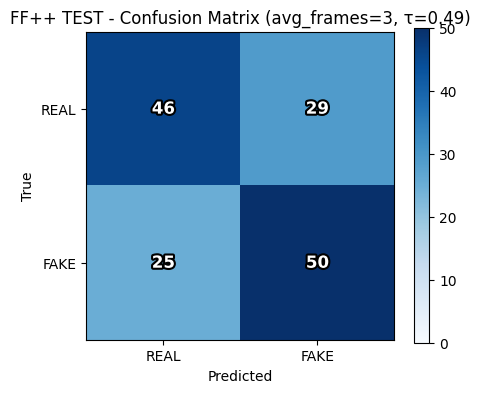

In [117]:

AVG_FRAMES = 3
frame_indices = get_frame_indices(X_val_rgb_seq.shape[1], AVG_FRAMES)

val_probs = predict_probs_frame_averaging(
    model, X_val_rgb_seq, X_val_dct_vec,
    img_size=IMG_SIZE, batch_size=BATCH_SIZE,
    frame_indices=frame_indices
)
tau_auto, bal = find_best_threshold_balanced_acc(y_val, val_probs)
print(f"Auto τ on FF++ VAL (balanced_acc): τ={tau_auto:.2f} (bal_acc={bal:.3f})")

test_probs = predict_probs_frame_averaging(
    model, X_test_rgb_seq, X_test_dct_vec,
    img_size=IMG_SIZE, batch_size=BATCH_SIZE,
    frame_indices=frame_indices
)
y_pred = (test_probs >= tau_auto).astype(int)

print("\nFFPP TEST report:")
print(classification_report(y_test.astype(int), y_pred, target_names=["REAL","FAKE"], zero_division=0))


cm = confusion_matrix(y_test.astype(int), y_pred)
labels = ["REAL", "FAKE"]

plt.figure(figsize=(4.8, 4))
ax = plt.gca()
im = ax.imshow(cm, cmap="Blues", vmin=0, vmax=cm.max())
plt.colorbar(im, ax=ax)

ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title(f"FF++ TEST - Confusion Matrix (avg_frames={AVG_FRAMES}, τ={tau_auto:.2f})")

for i in range(2):
    for j in range(2):
        ax.text(
            j, i, str(cm[i, j]),
            ha="center", va="center",
            fontsize=12, fontweight="bold",
            color="white",
            path_effects=[pe.withStroke(linewidth=3, foreground="black")]
        )

plt.tight_layout()
plt.show()


CelebDF TEST report (trained on FFPP, τ from FFPP val=0.49):
              precision    recall  f1-score   support

        REAL       0.55      0.41      0.47        75
        FAKE       0.53      0.67      0.59        75

    accuracy                           0.54       150
   macro avg       0.54      0.54      0.53       150
weighted avg       0.54      0.54      0.53       150



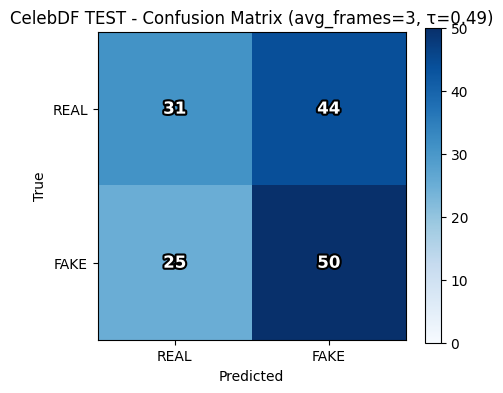

In [118]:

celeb_data = load_npz(Path(CELEB_NPZ))

ffpp_dmin = float(ffpp_data["dct_train_min"])
ffpp_dmax = float(ffpp_data["dct_train_max"])
eps = 1e-8

Xc_test_rgb = celeb_data["X_test_rgb"].astype(np.float32)
yc_test = celeb_data["y_test"].astype(int)

Xc_test_dct_raw = celeb_data["X_test_dct_raw"].astype(np.float32)
Xc_test_dct = (Xc_test_dct_raw - ffpp_dmin) / ((ffpp_dmax - ffpp_dmin) + eps)
Xc_test_dct_vec = Xc_test_dct.mean(axis=1).reshape(len(Xc_test_dct), -1).astype(np.float32)

frame_indices_celeb = get_frame_indices(Xc_test_rgb.shape[1], AVG_FRAMES)

tau = tau_auto
celeb_test_probs = predict_probs_frame_averaging(
    model, Xc_test_rgb, Xc_test_dct_vec,
    img_size=IMG_SIZE, batch_size=BATCH_SIZE,
    frame_indices=frame_indices_celeb
)
yc_pred = (celeb_test_probs >= tau).astype(int)

print(f"\nCelebDF TEST report (trained on FFPP, τ from FFPP val={tau:.2f}):")
print(classification_report(yc_test, yc_pred, target_names=["REAL","FAKE"], zero_division=0))

cm = confusion_matrix(yc_test, yc_pred)
labels = ["REAL", "FAKE"]

plt.figure(figsize=(4.8, 4))
ax = plt.gca()
im = ax.imshow(cm, cmap="Blues", vmin=0, vmax=cm.max())
plt.colorbar(im, ax=ax)

ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title(f"CelebDF TEST - Confusion Matrix (avg_frames={AVG_FRAMES}, τ={tau:.2f})")

for i in range(2):
    for j in range(2):
        ax.text(
            j, i, str(cm[i, j]),
            ha="center", va="center",
            fontsize=12, fontweight="bold",
            color="white",
            path_effects=[pe.withStroke(linewidth=3, foreground="black")]
        )

plt.tight_layout()
plt.show()

In [71]:
FT_LAYERS = 80
FT_LR = 5e-6
FT_EPOCHS = 12

# --- unfreeze last FT_LAYERS of EfficientNet backbone (BN frozen) ---
backbone = model.get_layer("efficientnetb0")
set_finetune_layers(backbone, FT_LAYERS)

# IMPORTANT: recompile after changing trainable flags
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

# --- callbacks + save paths ---
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
ft_best_path  = CKPT_DIR / f"ffpp_best_{run_id}_finetune_ft{FT_LAYERS}_lr{FT_LR}.keras"
ft_final_path = SAVED_DIR / f"ffpp_final_{run_id}_finetune.keras"

ft_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(ft_best_path),
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=7,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc",
        mode="max",
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1,
    ),
]

print(f"Fine-tuning last {FT_LAYERS} backbone layers @ lr={FT_LR} ...")
ft_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT_EPOCHS,
    callbacks=ft_callbacks,
)

model.save(str(ft_final_path))
print("Saved fine-tuned best checkpoint:", ft_best_path)
print("Saved fine-tuned final model:", ft_final_path)

Fine-tuning last 80 backbone layers @ lr=5e-06 ...
Epoch 1/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6716 - auc: 0.7375 - loss: 0.6187 - precision: 0.7042 - recall: 0.5874
Epoch 1: val_auc improved from None to 0.63858, saving model to C:\Users\Omar-\Desktop\DeepFake\model\checkpoints\ffpp_best_20251216_205418_finetune_ft80_lr5e-06.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 55s 378ms/step - accuracy: 0.6743 - auc: 0.7380 - loss: 0.6169 - precision: 0.6753 - recall: 0.6714 - val_accuracy: 0.6200 - val_auc: 0.6386 - val_loss: 0.6639 - val_precision: 0.6324 - val_recall: 0.5733 - learning_rate: 5.0000e-06
Epoch 2/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.6649 - auc: 0.7406 - loss: 0.6128 - precision: 0.6800 - recall: 0.6715
Epoch 2: val_auc improved from 0.63858 to 0.66427, saving model to C:\Users\Omar-\Desktop\DeepFake\model\checkpoints\ffpp_best_20251216_205418_finetune_ft80_lr5e-06.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 317ms/step - accuracy: 0.6686 - auc: 0.7341 -


[FINETUNE] Auto τ on FFPP VAL (balanced_acc): τ=0.54 (bal_acc=0.787)

[FINETUNE] FFPP TEST report:
              precision    recall  f1-score   support

        REAL       0.79      0.79      0.79        75
        FAKE       0.79      0.79      0.79        75

    accuracy                           0.79       150
   macro avg       0.79      0.79      0.79       150
weighted avg       0.79      0.79      0.79       150



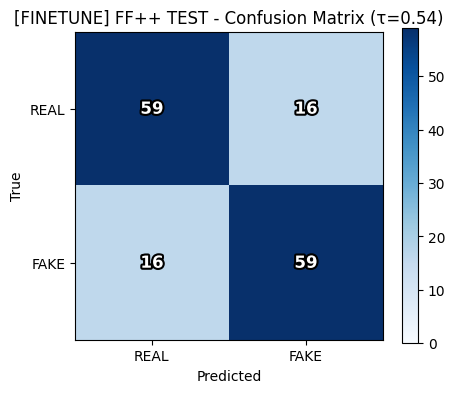

In [ ]:
import matplotlib.patheffects as pe

AVG_FRAMES = 3
frame_indices = get_frame_indices(X_val_rgb_seq.shape[1], AVG_FRAMES)

# ---- choose tau on FFPP val ----
val_probs = predict_probs_frame_averaging(
    model, X_val_rgb_seq, X_val_dct_vec,
    img_size=IMG_SIZE, batch_size=BATCH_SIZE,
    frame_indices=frame_indices
)
tau_auto, bal = find_best_threshold_balanced_acc(y_val, val_probs)
print(f"\n[FINETUNE] Auto τ on FF++ VAL (balanced_acc): τ={tau_auto:.2f} (bal_acc={bal:.3f})")

# ---- FFPP test ----
test_probs = predict_probs_frame_averaging(
    model, X_test_rgb_seq, X_test_dct_vec,
    img_size=IMG_SIZE, batch_size=BATCH_SIZE,
    frame_indices=frame_indices
)
y_pred = (test_probs >= tau_auto).astype(int)

print("\n[FINETUNE] FF++ TEST report:")
print(classification_report(y_test.astype(int), y_pred, target_names=["REAL","FAKE"], zero_division=0))

# ---- Confusion matrix (plot) ----
cm = confusion_matrix(y_test.astype(int), y_pred)

plt.figure(figsize=(4.8, 4))
ax = plt.gca()
im = ax.imshow(cm, cmap="Blues", vmin=0, vmax=cm.max())
plt.colorbar(im, ax=ax)

labels = ["REAL", "FAKE"]
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title(f"[FINETUNE] FF++ TEST - Confusion Matrix (τ={tau_auto:.2f})")

# numbers with outline so they’re readable on any color
for i in range(2):
    for j in range(2):
        ax.text(
            j, i, str(cm[i, j]),
            ha="center", va="center",
            fontsize=12, fontweight="bold",
            color="white",
            path_effects=[pe.withStroke(linewidth=3, foreground="black")]
        )

plt.tight_layout()
plt.show()


[FINETUNE] CelebDF TEST report (trained on FFPP, τ from FFPP val=0.54):
              precision    recall  f1-score   support

        REAL       0.65      0.53      0.58        75
        FAKE       0.60      0.71      0.65        75

    accuracy                           0.62       150
   macro avg       0.62      0.62      0.62       150
weighted avg       0.62      0.62      0.62       150



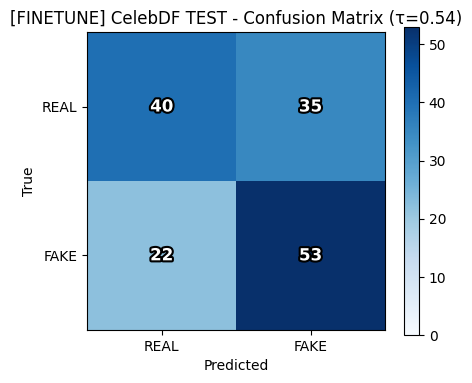

In [ ]:
celeb_data = load_npz(Path(CELEB_NPZ))

ffpp_dmin = float(ffpp_data["dct_train_min"])
ffpp_dmax = float(ffpp_data["dct_train_max"])
eps = 1e-8

Xc_test_rgb = celeb_data["X_test_rgb"].astype(np.float32)
yc_test = celeb_data["y_test"].astype(int)

Xc_test_dct_raw = celeb_data["X_test_dct_raw"].astype(np.float32)
Xc_test_dct = (Xc_test_dct_raw - ffpp_dmin) / ((ffpp_dmax - ffpp_dmin) + eps)
Xc_test_dct_vec = Xc_test_dct.mean(axis=1).reshape(len(Xc_test_dct), -1).astype(np.float32)

frame_indices_celeb = get_frame_indices(Xc_test_rgb.shape[1], AVG_FRAMES)

celeb_test_probs = predict_probs_frame_averaging(
    model, Xc_test_rgb, Xc_test_dct_vec,
    img_size=IMG_SIZE, batch_size=BATCH_SIZE,
    frame_indices=frame_indices_celeb
)
yc_pred = (celeb_test_probs >= tau_auto).astype(int)

print(f"\n[FINETUNE] CelebDF TEST report (trained on FF++, τ from FF++ val={tau_auto:.2f}):")
print(classification_report(yc_test, yc_pred, target_names=["REAL","FAKE"], zero_division=0))

# ---- Confusion matrix (plot) ----
cm = confusion_matrix(yc_test, yc_pred)

plt.figure(figsize=(4.8, 4))
ax = plt.gca()
im = ax.imshow(cm, cmap="Blues", vmin=0, vmax=cm.max())
plt.colorbar(im, ax=ax)

labels = ["REAL", "FAKE"]
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title(f"[FINETUNE] CelebDF TEST - Confusion Matrix (τ={tau_auto:.2f})")

# Text with outline so it stays readable
for i in range(2):
    for j in range(2):
        ax.text(
            j, i, str(cm[i, j]),
            ha="center", va="center",
            fontsize=12, fontweight="bold",
            color="white",
            path_effects=[pe.withStroke(linewidth=3, foreground="black")]
        )


## Phase 3 — Grad-CAM (XAI) on One Sample

In [74]:

preprocess_input = tf.keras.applications.efficientnet.preprocess_input

def _prepare_rgb_for_model(img_01: np.ndarray, img_size: int = 224) -> tf.Tensor:
    # img_01: BGR float 0..1
    x = tf.convert_to_tensor(img_01, dtype=tf.float32)
    x = tf.image.resize(x, (img_size, img_size))
    x = preprocess_input(x * 255.0)
    return tf.expand_dims(x, 0)

def _prepare_dct_for_model(dct_vec: np.ndarray) -> tf.Tensor:
    x = tf.convert_to_tensor(dct_vec, dtype=tf.float32)
    return tf.expand_dims(x, 0)

def _resolve_connected_conv_tensor(model: tf.keras.Model, target_layer: str | None, backbone_name: str = "efficientnetb0"):
    fallback = model.get_layer("rgb_global_pool").input  # (None,H,W,C)
    try:
        backbone = model.get_layer(backbone_name)
    except Exception:
        return fallback

    if target_layer is None:
        target_layer = "top_conv"
    try:
        inner_layer = backbone.get_layer(target_layer)
    except Exception:
        return fallback

    inner_model = tf.keras.Model(inputs=backbone.input, outputs=inner_layer.output)
    conv_tensor = inner_model(model.inputs[0])

    if len(conv_tensor.shape) != 4:
        return fallback
    return conv_tensor

def compute_gradcam(model, img_01, dct_vec, target_layer=None, img_size=224, target="fake"):
    conv_tensor = _resolve_connected_conv_tensor(model, target_layer)
    grad_model = tf.keras.models.Model(inputs=model.inputs, outputs=[conv_tensor, model.output])

    rgb_in = _prepare_rgb_for_model(img_01, img_size)
    dct_in = _prepare_dct_for_model(dct_vec)

    with tf.GradientTape() as tape:
        conv_out, pred = grad_model([rgb_in, dct_in], training=False)
        tape.watch(conv_out)
        prob_fake = pred[:, 0]
        score = prob_fake if target.lower() == "fake" else (1.0 - prob_fake)

    grads = tape.gradient(score, conv_out)
    if grads is None:
        raise RuntimeError("Gradients are None (try another sample or use target_layer=None).")

    weights = tf.reduce_mean(grads, axis=(1, 2))[0]
    cam = tf.reduce_sum(conv_out[0] * weights[tf.newaxis, tf.newaxis, :], axis=-1)

    cam = tf.nn.relu(cam).numpy()
    cam = cv2.resize(cam, (img_size, img_size), interpolation=cv2.INTER_LINEAR)

    cam_min, cam_max = float(cam.min()), float(cam.max())
    if cam_max - cam_min < 1e-8:
        return np.zeros((img_size, img_size), dtype=np.float32)

    cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
    return cam.astype(np.float32)

def overlay_heatmap(img_01: np.ndarray, heatmap: np.ndarray, alpha: float = 0.45):
    img_bgr = (np.clip(img_01, 0, 1) * 255).astype(np.uint8)
    hm = (np.clip(heatmap, 0, 1) * 255).astype(np.uint8)
    hm_color = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    return cv2.addWeighted(img_bgr, 1 - alpha, hm_color, alpha, 0)

True: REAL | Pred: REAL | prob_fake=0.416 | τ=0.54


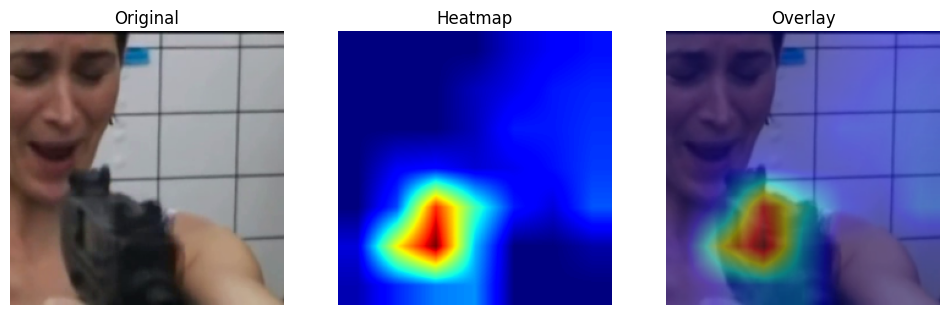

Heatmap stats: 0.0 0.9999997615814209 0.1380174309015274


In [101]:

idx = 64
T = Xc_test_rgb.shape[1]
center = T // 2

img_01 = Xc_test_rgb[idx, center]  # BGR float 0..1
y_true = int(yc_test[idx])

# Use RAW DCT from celeb normalized by FFPP stats
dct_raw = celeb_data["X_test_dct_raw"][idx].astype(np.float32)
dct_norm = (dct_raw - ffpp_dmin) / ((ffpp_dmax - ffpp_dmin) + 1e-8)
dct_vec = dct_norm.mean(axis=0).reshape(-1).astype(np.float32)

# Prediction
rgb_in = _prepare_rgb_for_model(img_01, IMG_SIZE)
dct_in = _prepare_dct_for_model(dct_vec)
prob_fake = float(model([rgb_in, dct_in], training=False).numpy().squeeze())
y_pred = int(prob_fake >= tau_auto)

name = lambda y: "FAKE" if y == 1 else "REAL"
print(f"True: {name(y_true)} | Pred: {name(y_pred)} | prob_fake={prob_fake:.3f} | τ={tau_auto:.2f}")

target = "fake" if y_pred == 1 else "real"
heat = compute_gradcam(model, img_01, dct_vec, target_layer="None", img_size=IMG_SIZE, target=target)
overlay_bgr = overlay_heatmap(img_01, heat, alpha=0.45)

orig_rgb = cv2.cvtColor((img_01 * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 4))
for i, (title, im, cmap) in enumerate([
    ("Original", orig_rgb, None),
    ("Heatmap", heat, "jet"),
    ("Overlay", overlay_rgb, None),
]):
    ax = plt.subplot(1, 3, i + 1)
    ax.set_title(title)
    ax.axis("off")
    if cmap:
        ax.imshow(im, cmap=cmap)
    else:
        ax.imshow(im)

plt.show()

print("Heatmap stats:", float(heat.min()), float(heat.max()), float(heat.mean()))

True: FAKE | Pred: FAKE | prob_fake=0.832 | τ=0.54


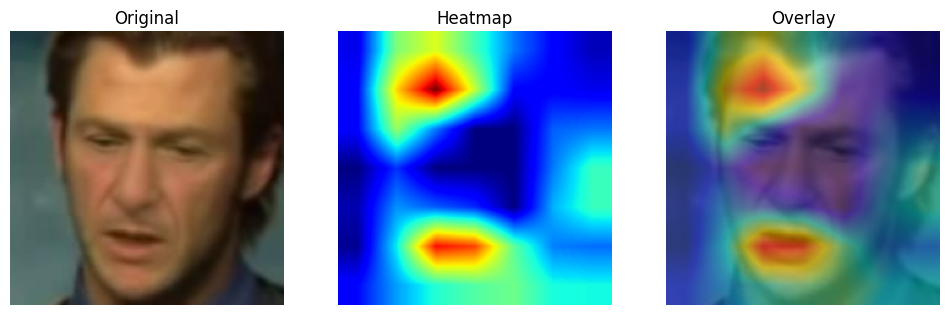

Heatmap stats: 0.0 0.9999995231628418 0.28522107005119324


In [93]:

idx = 130
T = Xc_test_rgb.shape[1]
center = T // 2

img_01 = Xc_test_rgb[idx, center]  # BGR float 0..1
y_true = int(yc_test[idx])

# Use RAW DCT from celeb normalized by FFPP stats
dct_raw = celeb_data["X_test_dct_raw"][idx].astype(np.float32)
dct_norm = (dct_raw - ffpp_dmin) / ((ffpp_dmax - ffpp_dmin) + 1e-8)
dct_vec = dct_norm.mean(axis=0).reshape(-1).astype(np.float32)

# Prediction
rgb_in = _prepare_rgb_for_model(img_01, IMG_SIZE)
dct_in = _prepare_dct_for_model(dct_vec)
prob_fake = float(model([rgb_in, dct_in], training=False).numpy().squeeze())
y_pred = int(prob_fake >= tau_auto)

name = lambda y: "FAKE" if y == 1 else "REAL"
print(f"True: {name(y_true)} | Pred: {name(y_pred)} | prob_fake={prob_fake:.3f} | τ={tau_auto:.2f}")

target = "fake" if y_pred == 1 else "real"
heat = compute_gradcam(model, img_01, dct_vec, target_layer="None", img_size=IMG_SIZE, target=target)
overlay_bgr = overlay_heatmap(img_01, heat, alpha=0.45)

orig_rgb = cv2.cvtColor((img_01 * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 4))
for i, (title, im, cmap) in enumerate([
    ("Original", orig_rgb, None),
    ("Heatmap", heat, "jet"),
    ("Overlay", overlay_rgb, None),
]):
    ax = plt.subplot(1, 3, i + 1)
    ax.set_title(title)
    ax.axis("off")
    if cmap:
        ax.imshow(im, cmap=cmap)
    else:
        ax.imshow(im)

plt.show()

print("Heatmap stats:", float(heat.min()), float(heat.max()), float(heat.mean()))

True: REAL | Pred: FAKE | prob_fake=0.592 | τ=0.54


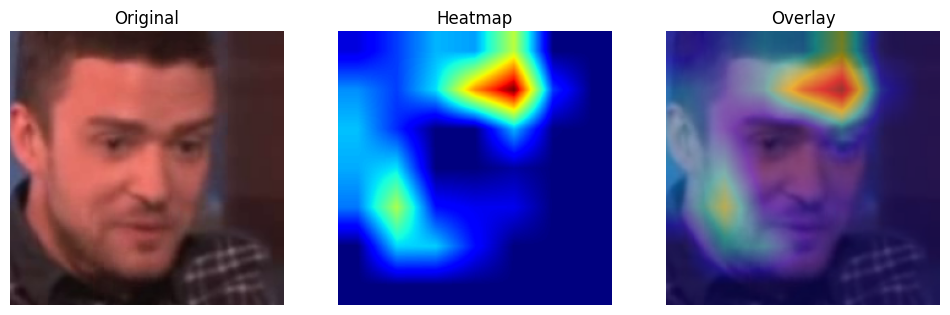

Heatmap stats: 0.0 0.9999997019767761 0.15460439026355743


In [109]:

idx = 129
T = Xc_test_rgb.shape[1]
center = T // 2

img_01 = Xc_test_rgb[idx, center]  # BGR float 0..1
y_true = int(yc_test[idx])

# Use RAW DCT from celeb normalized by FFPP stats
dct_raw = celeb_data["X_test_dct_raw"][idx].astype(np.float32)
dct_norm = (dct_raw - ffpp_dmin) / ((ffpp_dmax - ffpp_dmin) + 1e-8)
dct_vec = dct_norm.mean(axis=0).reshape(-1).astype(np.float32)

# Prediction
rgb_in = _prepare_rgb_for_model(img_01, IMG_SIZE)
dct_in = _prepare_dct_for_model(dct_vec)
prob_fake = float(model([rgb_in, dct_in], training=False).numpy().squeeze())
y_pred = int(prob_fake >= tau_auto)

name = lambda y: "FAKE" if y == 1 else "REAL"
print(f"True: {name(y_true)} | Pred: {name(y_pred)} | prob_fake={prob_fake:.3f} | τ={tau_auto:.2f}")

target = "fake" if y_pred == 1 else "real"
heat = compute_gradcam(model, img_01, dct_vec, target_layer="None", img_size=IMG_SIZE, target=target)
overlay_bgr = overlay_heatmap(img_01, heat, alpha=0.45)

orig_rgb = cv2.cvtColor((img_01 * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 4))
for i, (title, im, cmap) in enumerate([
    ("Original", orig_rgb, None),
    ("Heatmap", heat, "jet"),
    ("Overlay", overlay_rgb, None),
]):
    ax = plt.subplot(1, 3, i + 1)
    ax.set_title(title)
    ax.axis("off")
    if cmap:
        ax.imshow(im, cmap=cmap)
    else:
        ax.imshow(im)

plt.show()

print("Heatmap stats:", float(heat.min()), float(heat.max()), float(heat.mean()))